In [103]:
%matplotlib inline 
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy import sqrt, sin, cos, pi, cosh, sinh, tanh, exp, linalg, log
from sympy import symbols, solve
import math
from  scipy.sparse.linalg import eigsh

Let us write a function which creates a matrix consisting of two blocks with prescribed values(later we will write a general with k blocks)

In [104]:
def create_two_blocks(dimension, size1, value11, value12, value22): 
    #Returns a symmetric matrix consisting of two blocks with prescribed values 
    delta = np.zeros((dimension, dimension))
    delta[:size1, :size1] = value11
    delta[size1:, :size1] = value12
    delta[:size1, size1:] = value12
    delta[size1:, size1:] = value22
    return delta

In [105]:
create_two_blocks(10, 4, 1, 3, 5)

array([[1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.],
       [3., 3., 3., 3., 5., 5., 5., 5., 5., 5.]])

### Instance of the problem

Let us generate an instance of the problem with inhomogenous noise (delta instead of snr)

In [106]:
def get_instance(dimension, prior, delta):
    #Returns a ground truth vector and the matrix corrupted by a gaussian noise according to the model
    if prior =='gaussian':
        true_vector = np.random.normal(0,1, (dimension,1))       
    elif prior == 'radamacher':
        true_vector = np.random.choice([-1,1], size=(dimension, 1))
        
    noise = np.triu(np.random.normal(0, 1, (dimension,dimension)))
    noise = noise + noise.T + np.diag(np.random.normal(0,1, dimension))
    
    corrupted_matrix = np.sqrt(1 / dimension) * true_vector @ true_vector.T + noise * delta

    return true_vector, corrupted_matrix

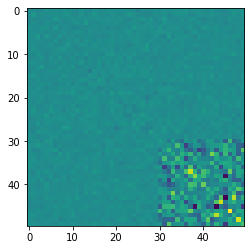

In [107]:
delta = create_two_blocks(dimension = 50, size1 = 30, value11 = 1, value12 = 1, value22 = 8)
Y = get_instance(dimension = 50, prior = 'gaussian', delta = delta)[1]
plt.imshow(Y, interpolation = 'none')
plt.show()

The plot above clearly illustrates the presence of two communities in the generated instance. In the first community the variance is 1 and the color is quite uniform, whereas in the second the variance is 8 and the color varies wildly across different nodes from the same community.

Let us now implement AMP for the inhomegenous noise 

In [108]:
def damp(new, old, damping=0.25):
    return damping * old + (1-damping) * new

def iterate_amp(precision = 1e-5, max_steps = 100, *, init, prior, Y, delta):
    
    N = Y.shape[0]
    
    estimator = init
    previous_estimator = np.copy(init)
    derivative = np.zeros(N) 
    
    converged = False
    
    a_previous = 0
    b_previous = np.zeros(N)
    #parameters of the integral calculating the Bayesian-optimal denoising
    
    for timestep in range(max_steps):   
        snr = [np.mean (estimator**2) / np.mean((delta[j] * estimator)**2) for j in range(N)]
        Onsager_term = [np.mean (delta[j]**2 * derivative) for j in range(N)]
        snr = np.array(snr)
        Onsager_term = np.array(Onsager_term)
        
        next_step = np.sqrt(1 / N) * Y.T @ estimator - Onsager_term * previous_estimator
        a = snr * np.mean(estimator**2) 
        b = snr * next_step
        
        if timestep != 0:
            a = damp(a, a_previous)
            b = damp(b, b_previous)
            
        previous_estimator = estimator
        estimator, derivative = denoiser_and_derivative(b, a, prior = prior)
        derivative *= snr
        
        step_difference = np.mean((estimator-previous_estimator)**2)
        a_previous = np.copy(a)
        b_previous = np.copy(b)
        
        if (timestep > 2) and (step_difference < precision):
            converged = True
            break
            
    if not converged:
        print("AMP didn't converge!")
    
    return estimator

Now we implement the denoiser functions. Note that with inhomegenous noise both parameters b and a are vectors

In [109]:
def denoiser_and_derivative(b, a, *, prior):
    if(prior == 'gaussian'):
        return b/(1+a), 1/(1+a) 
    elif prior == 'radamacher':
        return np.tanh(b), 1-np.tanh(b)**2

We now calculate the average performance of AMP over several runs

In [110]:
def get_mse(truth, estimate):
    first_possibility = np.mean((truth - estimate)**2)
    second_possibility = np.mean((truth + estimate)**2)
    return min(first_possibility, second_possibility) #It is impossible to learn the sign

def get_averaged_performance(seeds, dimension, initialisation = 'uninformed', *, prior, delta):
    mse = []
    N = dimension
    for _ in range(seeds):
        init = 1e-3 * np.random.normal(0,1,(N,1)) # default initialisation is uninformed
        # Generate an instance
        truth, Y = get_instance(dimension = dimension, 
                             prior = prior, 
                             delta = delta)
        
        # In informed initialisation start close to signal
        if initialisation == 'informed':
            init += truth 
        elif initialisation == 'spectral':
            _, init = np.linalg.eigh(Y)[N-1]
            init *= np.sqrt(len(truth))
        estimate = iterate_amp(init = init, 
                                 prior = prior, 
                                 Y = Y, 
                                 delta = delta)
        mse.append(get_mse(truth, estimate))
        
    return np.mean(mse)

In [111]:
def data_amp(seeds, dimension, initialisation = 'uninformed', *, delta_collection, prior):
    
    data = {'parameter': [], 'mse': []}
    for delta in delta_collection:
        parameter = delta[0][0]
        print("Computing with parameter = {}".format(parameter))
        
        mse = get_averaged_performance(seeds = seeds,dimension = dimension, 
                                            initialisation = initialisation, 
                                            prior = prior, 
                                            delta = delta)
        
        data['parameter'].append(parameter)
        data['mse'].append(mse)

    return data

In [112]:
def create_two_blocks_collection(dimension, *, start, end, points, first_size, diag_scalar):
    N = dimension
    parameter_range = np.linspace(start, end, points)
    delta_collection = []
    for parameter in parameter_range:
        delta_collection.append(create_two_blocks(N, first_size, parameter, parameter, diag_scalar * parameter))
    return np.array(delta_collection)


Code to solve the variational problem

In [113]:
def ExpectGibbs(qtilde):
  return 1 - 1/(qtilde + 1)

def iterate(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,damping):
  term1 =  ExpectGibbs(Qtilde1)
  term2 = ExpectGibbs(Qtilde2)
  newQtilde1 = (rho1/Delta_11) * term1 + (rho2/Delta_12)*term2
  newQtilde2 = (rho1/Delta_12) * term1 + (rho2/Delta_22)*term2
  return (1-damping)*newQtilde1+damping*Qtilde1, (1-damping)*newQtilde2+damping*Qtilde2,sqrt((newQtilde1-Qtilde1)**2+(newQtilde2-Qtilde2)**2)

def ComputeQ(Qtilde1,Qtilde2):
  return  ExpectGibbs(Qtilde1), ExpectGibbs(Qtilde2)

def FreeEnergy(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22): #computation of the free energy
  Q1, Q2 = ComputeQ(Qtilde1,Qtilde2)
  return -rho1*rho1*Q1*Q1/Delta_11/4 - rho2*rho2*Q2*Q2/Delta_22/4 - 2*rho1*rho2*Q1*Q2/Delta_12/4 + rho1/2 *( Qtilde1 - log(1 + Qtilde1) ) + rho2/2*( Qtilde2 - log(1 + Qtilde2) )

def Solve_Q(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22):
    conv = 1000
    it = 0
    while (conv>1e-6):
      it = it +1
      damping = 1      
      ok = 0
      t = 0 
      oldconv = conv
      while (ok ==0):
        t = t + 1
        Qtilde1,Qtilde2,conv = iterate(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,damping)
        if (conv<oldconv):
          ok = 1
        if (t>100):
          ok = 1
        damping = damping / 1.2
    #  print(it,t,damping*1.2,Qtilde1,Qtilde2,conv)      
    return Qtilde1,Qtilde2

In [114]:
def visualize (data_amp, data_optimal):
    fig, ax = plt.subplots(figsize=(12,10))
    plt.plot(data_optimal['parameter'], data_optimal['mse'], 
         '-y', label='Optimal', color='blue')
    plt.plot(data_amp['parameter'], data_amp['mse'], 
         '.', label='AMP', color='red')
    plt.xlabel('param')
    plt.ylabel('mse')
    plt.legend()

Generating the MMSE

In [115]:
def optimal_curve(start, end, points, diag_scalar):

    rho1, rho2 = 0.5, 0.5
    Delta11 = 1
    Delta12 = 1
    Delta22 = diag_scalar

    Q1 = 1
    Q2 = 1
    Qtilde1 = rho1/Delta11**2*Q1 + rho2/Delta12**2*Q2
    Qtilde2 = rho1/Delta12**2*Q1 + rho2/Delta22**2*Q2

    MMSEVec = []
    paramvec = []

    param_range = np.linspace(start, end, points)

    for param in param_range:
      Delta_11_new = param**2
      Delta_12_new = param**2
      Delta_22_new = (diag_scalar*param)**2
      Qtilde1,Qtilde2 = Solve_Q(Qtilde1,Qtilde2,rho1,rho2,Delta_11_new,Delta_12_new,Delta_22_new)
      MMSEVec.append( 1 - ( rho1**2 * ExpectGibbs(Qtilde1)*ExpectGibbs(Qtilde1) + 
                           2*rho1*rho2 *  ExpectGibbs(Qtilde1) * ExpectGibbs(Qtilde2) + 
                           rho2**2 * ExpectGibbs(Qtilde2) * ExpectGibbs(Qtilde2) )  )
      paramvec.append(param)
    
    return {'parameter': paramvec, 'mse': MMSEVec}


Computing with parameter = 0.05
Computing with parameter = 0.07346938775510203
Computing with parameter = 0.09693877551020408
Computing with parameter = 0.12040816326530611
Computing with parameter = 0.14387755102040817
Computing with parameter = 0.1673469387755102
Computing with parameter = 0.1908163265306122
Computing with parameter = 0.21428571428571425
Computing with parameter = 0.2377551020408163
Computing with parameter = 0.26122448979591834
Computing with parameter = 0.2846938775510204
Computing with parameter = 0.3081632653061224
Computing with parameter = 0.3316326530612244
Computing with parameter = 0.35510204081632646
Computing with parameter = 0.3785714285714285
Computing with parameter = 0.40204081632653055
Computing with parameter = 0.4255102040816326
Computing with parameter = 0.44897959183673464
Computing with parameter = 0.4724489795918367
Computing with parameter = 0.4959183673469387
Computing with parameter = 0.5193877551020408
Computing with parameter = 0.5428571428

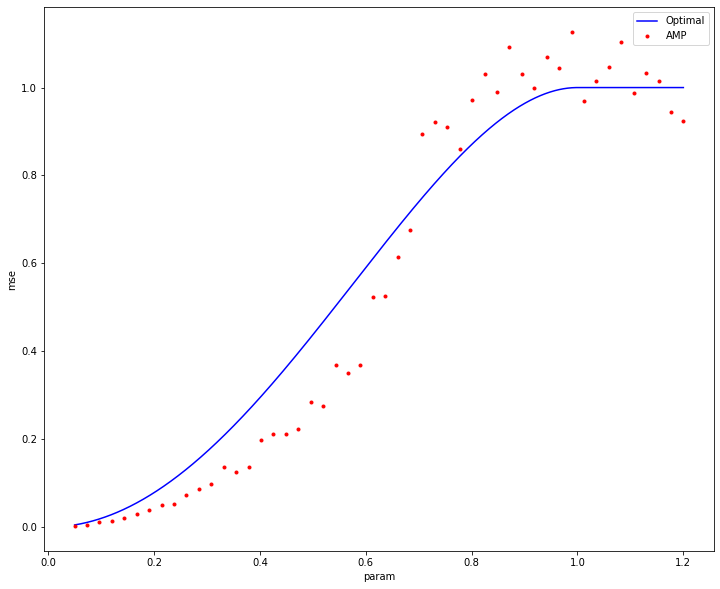

In [116]:
dimension = 75
start = 0.05
end = 1.2
points = 50
delta_collection = create_two_blocks_collection(dimension = dimension, start = start, end = end, points = points, 
                                         first_size = dimension//2, diag_scalar = 1)
gaussian_prior = data_amp(initialisation = 'uninformed', seeds = 10, dimension = dimension,
                                   delta_collection = delta_collection, prior = 'gaussian')
visualize(data_amp = gaussian_prior, data_optimal = 
          optimal_curve(start = start, end = end, points = 1000, diag_scalar = 1))